# Dynamic Pricing for Urban Parking Lots

Urban parking lots often suffer from inefficiencies due to static pricing. This project builds a dynamic pricing system for 14 urban parking spaces, using real-time data (occupancy, traffic, events, vehicle types) to adjust prices intelligently. The goal is to improve utilization and maximize revenue.

## Tech Stack

- Python 3.x
- Pandas
- Numpy
- Pathway (for real-time streaming)
- Bokeh (for interactive visualizations)
- Google Colab
- GitHub


## Project Workflow

- **Data Ingestion:** Pathway reads the dataset as a real-time stream.
- **Feature Engineering:** Calculate occupancy rates, map vehicle types to numeric weights, and prepare demand features.
- **Dynamic Pricing Models:**
  - Model 1: Baseline price increases linearly with occupancy.
  - Model 2: Price determined by a demand function using occupancy, queue length, traffic, special days, and vehicle type.
  - Model 3: Competitor-aware pricing, adjusting based on nearby parking lot prices and capacity.
- **Visualization:** Real-time plots built using Bokeh to show dynamic price trends.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset (1).csv


In [4]:
import pandas as pd

df = pd.read_csv('dataset.csv')

# taking a look at data
print(df.shape)
print(df.head())
print(df.info())


(18368, 12)
   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy VehicleType  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61         car   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64         car   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80         car   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107         car   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150        bike   

  TrafficConditionNearby  QueueLength  IsSpecialDay LastUpdatedDate  \
0                    low            1             0      04-10-2016   
1                    low            1             0      04-10-2016   
2                    low            2             0      04-10-2016   
3                    low            2             0      04-10-2016   
4                    low            2             0      04-10-2016   

  LastUpdatedTime  
0        07:59:00  
1        08:25:00  
2        08:59

In [6]:
print(df.isnull().sum())

ID                        0
SystemCodeNumber          0
Capacity                  0
Latitude                  0
Longitude                 0
Occupancy                 0
VehicleType               0
TrafficConditionNearby    0
QueueLength               0
IsSpecialDay              0
LastUpdatedDate           0
LastUpdatedTime           0
dtype: int64


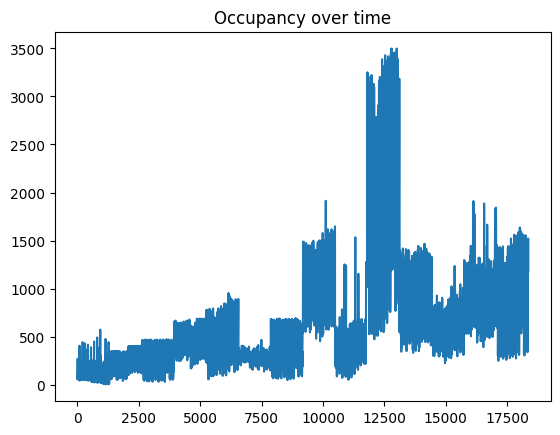

In [7]:
import matplotlib.pyplot as plt

plt.plot(df['Occupancy'])
plt.title('Occupancy over time')
plt.show()


In [10]:
df.fillna(0, inplace=True)
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
vehicle_weights = {
    'Car': 1,
    'Bike': 0.5,
    'Truck': 2
}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights)


In [11]:
base_price = 10
alpha = 2

# Simple baseline price:
df['BaselinePrice'] = base_price + alpha * df['OccupancyRate']

# Bound price between $5 and $20:
df['BaselinePrice'] = df['BaselinePrice'].clip(5, 20)


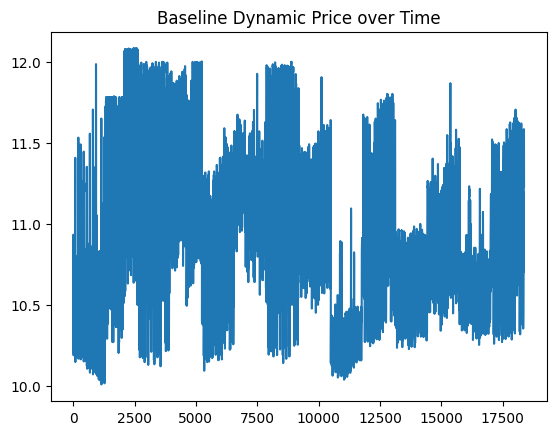

In [12]:
import matplotlib.pyplot as plt

plt.plot(df['BaselinePrice'])
plt.title('Baseline Dynamic Price over Time')
plt.show()


In [15]:
print(df.dtypes)


ID                          int64
SystemCodeNumber           object
Capacity                    int64
Latitude                  float64
Longitude                 float64
Occupancy                   int64
VehicleType                object
TrafficConditionNearby     object
QueueLength                 int64
IsSpecialDay                int64
LastUpdatedDate            object
LastUpdatedTime            object
OccupancyRate             float64
VehicleWeight             float64
BaselinePrice             float64
dtype: object


In [16]:
print(df.head)

<bound method NDFrame.head of           ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy  \
0          0      BHMBCCMKT01       577  26.144536  91.736172         61   
1          1      BHMBCCMKT01       577  26.144536  91.736172         64   
2          2      BHMBCCMKT01       577  26.144536  91.736172         80   
3          3      BHMBCCMKT01       577  26.144536  91.736172        107   
4          4      BHMBCCMKT01       577  26.144536  91.736172        150   
...      ...              ...       ...        ...        ...        ...   
18363  18363         Shopping      1920  26.150504  91.733531       1517   
18364  18364         Shopping      1920  26.150504  91.733531       1487   
18365  18365         Shopping      1920  26.150504  91.733531       1432   
18366  18366         Shopping      1920  26.150504  91.733531       1321   
18367  18367         Shopping      1920  26.150504  91.733531       1180   

      VehicleType TrafficConditionNearby  QueueLength  Is

In [17]:
traffic_map = {
    'low': 1,
    'average': 2,
    'high': 3
}

df['TrafficConditionNearby'] = df['TrafficConditionNearby'].map(traffic_map)


In [19]:
df['Demand'] = (
    alpha * df['OccupancyRate'] +
    beta * df['QueueLength'] -
    gamma * df['TrafficConditionNearby'] +
    delta * df['IsSpecialDay'] +
    epsilon * df['VehicleWeight']
)

In [20]:
demand_min = df['Demand'].min()
demand_max = df['Demand'].max()

df['NormalizedDemand'] = (df['Demand'] - demand_min) / (demand_max - demand_min)


In [21]:
lambda_ = 1

df['DemandPrice'] = 10 * (1 + lambda_ * df['NormalizedDemand'])
df['DemandPrice'] = df['DemandPrice'].clip(5, 20)


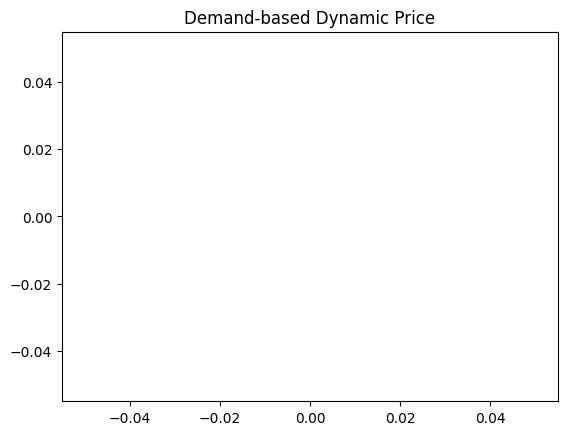

In [22]:
plt.plot(df['DemandPrice'])
plt.title('Demand-based Dynamic Price')
plt.show()


In [23]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [25]:
!pip install pathway
import pathway as pw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [1]:
import pathway as pw

table = pw.io.csv.read(
    path="/content/dataset.csv",
    schema=pw.schema_from_csv("/content/dataset.csv"),
    mode="streaming"
)

# Applying pricing logic here
# added a column for price:
# table = table.with_columns(...)

pw.io.csv.write(table, "/content/output.csv")

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [4]:
# STEP 1 — data loaded again
import pandas as pd

# Replaced with path or uploaded file
df = pd.read_csv('dataset.csv')

# DemandPrice column exists for this:
df['DemandPrice'] = 10 + (df['Occupancy'] / df['Capacity']) * 5

# STEP 2 — Plot with Bokeh
from bokeh.plotting import figure, show, output_notebook

output_notebook()

p = figure(title="Demand-based Price Over Time",
           x_axis_label='Time Index',
           y_axis_label='Price')

p.line(df.index, df['DemandPrice'], legend_label="Demand Price", line_width=2)

show(p)